<a href="https://colab.research.google.com/github/Next-Sunshine/TFF0318/blob/master/TestForTFFCopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 导包

In [0]:
#环境测试
#@test {"skip":true}
!pip install --quiet --upgrade tensorflow_federated
%load_ext tensorboard

     |████████████████████████████████| 430kB 4.8MB/s 
     |████████████████████████████████| 2.8MB 15.9MB/s 
     |████████████████████████████████| 2.2MB 40.6MB/s 
     |████████████████████████████████| 421.8MB 41kB/s 
     |████████████████████████████████| 102kB 11.5MB/s 
     |████████████████████████████████| 296kB 56.6MB/s 
     |████████████████████████████████| 20.0MB 160kB/s 
     |████████████████████████████████| 450kB 54.9MB/s 
     |████████████████████████████████| 3.9MB 58.7MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [0]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import h5py
import random
import math
import gc

tf.compat.v1.enable_v2_behavior()

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, world!')()

b'Hello, world!'

In [0]:
#装载数据集，实验使用EMNIST数据集
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()
#装载mnist数据集
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


### 加载EMNIST-digit数据集

In [0]:
#读取EMNIST数据集的Digit
# 引入必要的库函数:要把那四个gz文档上传上来
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.util.tf_export import tf_export
import gzip

# 读取本地gz文档，并转换为numpy矩阵的函数
def load_localData():
  #files = ['emnist-digits-train-labels-idx1-ubyte.gz', 'emnist-digits-train-images-idx3-ubyte.gz', 'emnist-digits-test-labels-idx1-ubyte.gz', 'emnist-digits-test-images-idx3-ubyte.gz']
  path = ['/content/drive/My Drive/Colab Notebooks/emnist-digits-train-labels-idx1-ubyte.gz', 
        '/content/drive/My Drive/Colab Notebooks/emnist-digits-train-images-idx3-ubyte.gz', 
        '/content/drive/My Drive/Colab Notebooks/emnist-digits-test-labels-idx1-ubyte.gz', 
        '/content/drive/My Drive/Colab Notebooks/emnist-digits-test-images-idx3-ubyte.gz']

  with gzip.open(path[0], 'rb') as lpath:
    y_train = np.frombuffer(lpath.read(), np.uint8, offset=8)
  with gzip.open(path[1], 'rb') as imgpath:
    x_train = np.frombuffer(imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)
  with gzip.open(path[2], 'rb') as lpath:
    y_test = np.frombuffer(lpath.read(), np.uint8, offset=8)
  with gzip.open(path[3], 'rb') as imgpath:
    x_test = np.frombuffer(imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28)
  return x_train, y_train, x_test, y_test

In [0]:
x_train_emnist_digits, y_train_emnist_digits, x_test_emnist_digits, y_test_emnist_digits = load_localData()

In [0]:
#查看某个客户端每个类别分别有多少
def num_per_class(label):
  num = np.zeros(shape=(10), dtype='int32')
  for i in range (len(label)):
    l = label[i]
    num[l] = num[l] + 1
  return num

In [0]:
#从mnist_train中读60000张图片放入一个数组中以备用
class_ = [[]for i in range(10)]
for i in range(len(x_train_emnist_digits)):
  label = y_train_emnist_digits[i]
  class_[label].append(x_train_emnist_digits[i])  #在对应的label中放入图片

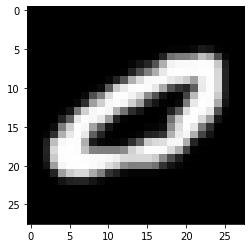

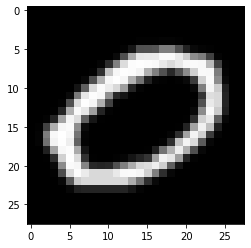

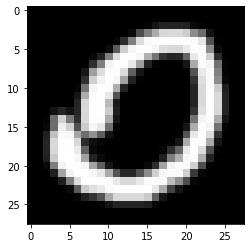

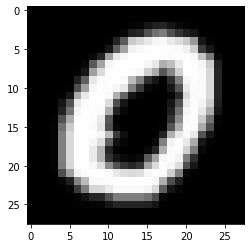

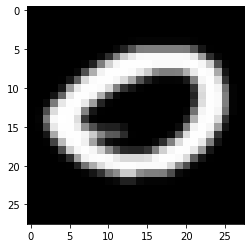

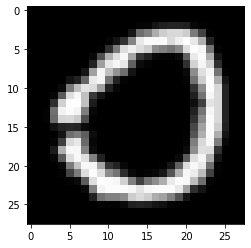

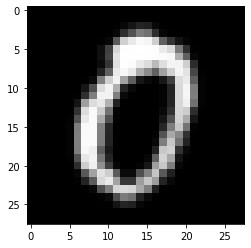

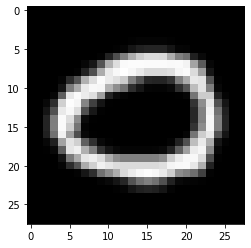

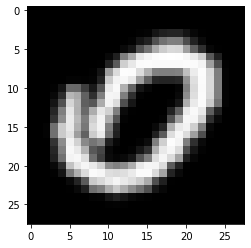

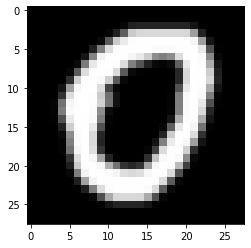

In [0]:
#查看提取出来的图片，以1为例,看看是否有误:没有错误
from matplotlib import pyplot as plt
#print(class_[0][i])
for i in range(10):
  plt.imshow(class_[0][i], cmap='gray', aspect='equal')
  plt.grid(False)
  _=plt.show()

### 构造平衡的测试集

In [0]:
'''
emnist中的数字测试集是平衡的，可以直接拿来用，共40000张图片，平均分给50个客户端
'''

In [0]:
#删除一个h5py文件
f_t.flush()
f_t.clear()

In [0]:
#创建文件
f_t = h5py.File("/content/drive/My Drive/Colab Notebooks/test.hdf5","w")
top_group = f_t.create_group("examples")

In [0]:
#将10个类别平均放到50个客户端中，每个客户端每个类别放80个
import random
NUM_CLIENTS = 50  #写的时候最初用50，用500时间太长
NUM_PER_CLASS = 80
NUM_CLASS = 10

pixels = [[]for i in range(NUM_CLIENTS)]
label = [[]for i in range(NUM_CLIENTS)]
client_ids = []
for i in range(len(y_test_emnist_digits)):
  #随机产生一个客户端的下标然后将该图片给放进去
    random_client_id = random.randint(0, NUM_CLIENTS-1)
    pixels[random_client_id].append(x_test_emnist_digits[i]/255.0)
    label[random_client_id].append(y_test_emnist_digits[i])
    
#将pixels和label加入对应client的group中
for i in range(NUM_CLIENTS):
  client_ids.append("f00_" + str(i))
  temp_group = top_group.create_group(name="f00_" + str(i))
  label_ds = temp_group.create_dataset(name="label", data=np.array(label[i], dtype='int32'))
  pixels_ds = temp_group.create_dataset(name="pixels", data=np.array(pixels[i], dtype='float32'))
  print(num_per_class(label[i]))


2


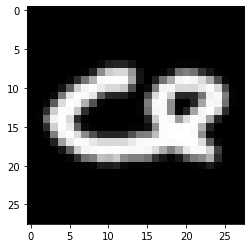

8


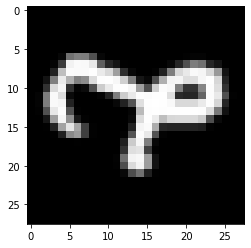

0


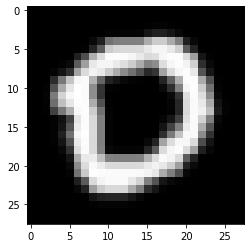

9


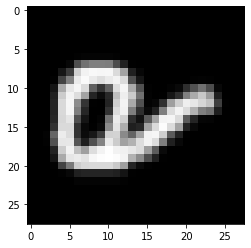

3


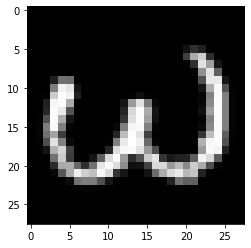

8


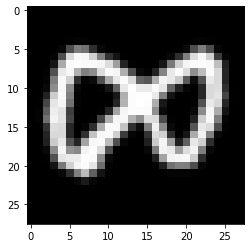

4


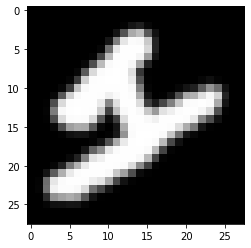

4


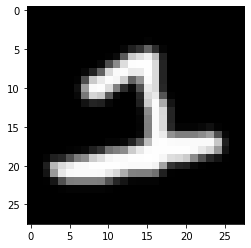

6


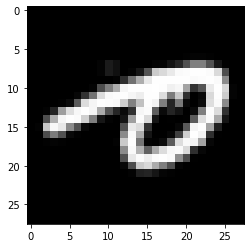

7


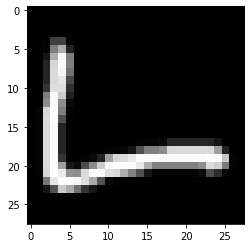

In [0]:
#查看数量是否有误
# num1 = 0
# num2 = 0
# for j in range(NUM_CLIENTS):
#   #print("pixels",len(pixels[j]))
#   num1 = num1 + len(pixels[j])
#   num2 = num2 + len(label[j])
#   #print("label",label[j])
# print(num1)
# print(num2)
# print(len(y_test_emnist_gidits))

#随机画图看是否有误:无误
#把图片画出来看一看
for i in range(10):
  print(f_t["examples"][client_ids[3]]["label"].value[i])
  plt.imshow(f_t["examples"][client_ids[3]]["pixels"].value[i],cmap='gray')
  plt.grid(False)
  plt.show()

In [0]:
#f_t.close()
del pixels[:]
del label[:]
gc.collect()

25758

### 构造BAL1数据集，标量平衡，全局平衡，局部IID

In [0]:
'''
K=100，每个客户端600张图片，每一类50张图片
'''

In [0]:
#当创建数据集需要修改的时候就要用这里，先清空再重新创建
f1.flush()
f1.clear()

In [0]:
#设置各个不平衡的数据集，首先弄一个BAL1:10个类别，每个类别数目相等，每个用户都含有10个类别且每类数目相等
#我调查的结果是每个label数目在5000-6000张之间，于是分给500个客户端差不多每个客户端均10个
#创建自己的数据集首先是BAL1：全平衡，使用了mnist数据集来分配，60000张图片平均分给500个客户端，每个客户端分得10类，每类10张，供100张图片
f1 = h5py.File("/content/drive/My Drive/Colab Notebooks/BAL1.hdf5","a")
top_group = f1.create_group("examples")   #创建顶层group名为examples

In [0]:
bal1_balance_class = [[]for i in range(10)]  
for i in range(0,10):
  bal1_balance_class[i] = class_[i][0:6000]

In [0]:
MY_NUM_CLIENTS = 100  #写的时候最初用50，用500时间太长，试过500，磁盘会从30G飙升到60G且还运行不完，不知道后面500个客户端的时候怎么办
NUM_PER_CLASS = 60  #每个客户端每类的图片数量
NUM_CLASS = 10
#Collections.Orderdict->TensorSliceDataset+client_id->hdf5->HDF5ClientData
#<TensorSliceDataset shapes: OrderedDict([(label, ()), (pixels, (28, 28))]), types: OrderedDict([(label, tf.int32), (pixels, tf.float32)])>

pixels = []
label=[]
client_ids = []
for i in range(MY_NUM_CLIENTS):  #i客户端数量
  for j in range(10):  #j是类别数
    for k in range(NUM_PER_CLASS): #k控制每一类图片放多少张在客户端
      pixels.append(bal1_balance_class[j][i*NUM_PER_CLASS+k]/255.0) #转成0-1之内的数字再加入pixels，class_[j]存放的是第j类数
      label.append(j)  #加入label
  
  client_ids.append("f00_" + str(i))
  temp_group = top_group.create_group(name="f00_" + str(i))  #创建以client_id为名字的group
  label_ds = temp_group.create_dataset(name="label", data=np.array(label, dtype='int32'))  #向group中写入label
  pixels_ds = temp_group.create_dataset(name="pixels", data=np.array(pixels, dtype='float32'))  #向group中写入pixels
  
  print(num_per_class(label))
  #清空上一个pixels数组和label数组中存放的上一个客户端的数据信息,否则会有灾难！！！
  pixels.clear()
  label.clear()


[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 60 60 60 60 60 60 60 60]
[60 60 6

1


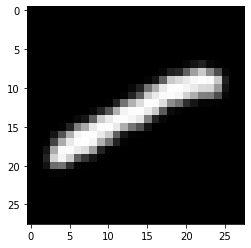

1


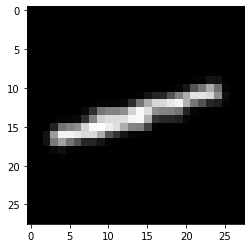

1


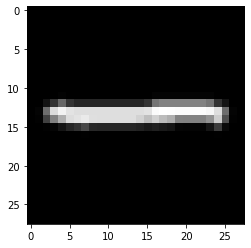

1


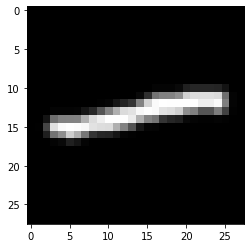

1


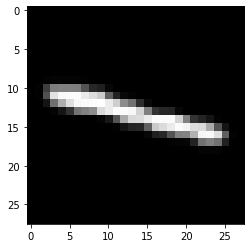

1


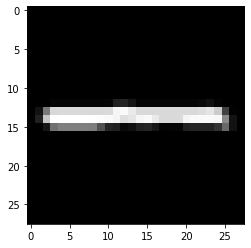

1


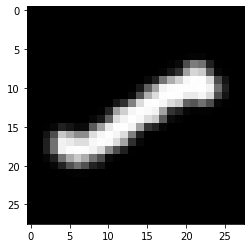

1


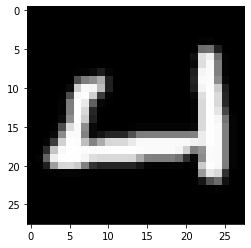

1


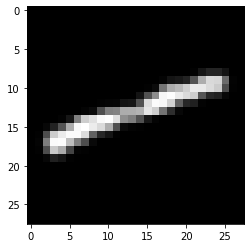

1


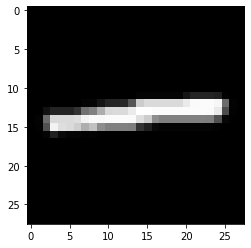

In [0]:
#查看数量是否有误



#随机画图看是否有误:无误
#把图片画出来看一看
for i in range(100,110):
  print(f1["examples"][client_ids[3]]["label"].value[i])
  plt.imshow(f1["examples"][client_ids[3]]["pixels"].value[i],cmap='gray')
  plt.grid(False)
  plt.show()

In [0]:
#数据集构造完了以后，调用内存清理操作
#f1.close()
del pixels[:]
del label[:]
del bal1_balance_class[:]
gc.collect()

23310

### 构造BAL2数据集：标量平衡且全局平衡，局部Non-IID

In [0]:
#构造BAL2
'''
标量平衡:每个本地600张
全局平衡：共10个类，每个类6000张
局部平衡：随机
num_clients = 100
'''

'\n标量平衡:每个本地100张\n全局平衡：共10个类，每个类10张\n局部平衡：随机\nnum_clients = 500\n'

In [0]:
#构造绝对平衡图片集,10张*10类*500个客户端
#因为后面构造数据集的时候对bal2_balance_class进行了删除操作，因此每次生成数据集都要重新生成bal2_balance_class
bal2_balance_class = [[]for i in range(10)]  
for i in range(0,10):
  bal2_balance_class[i] = class_[i][0:6000]

In [0]:
#删除一个h5py文件
f2.flush()
f2.clear()

In [0]:
#创建hdf5文件
f2 = h5py.File("/content/drive/My Drive/Colab Notebooks/BAL2.hdf5","a")
#创建顶层group
top_group = f2.create_group("examples")

In [0]:
#创建BAL2:使用了洗牌算法(弃了，Non-IID性不够)
#另外的方法：按label划分以后每300张为一个碎片，每个用户随机分配两个碎片
#将10个类别平均放到500个客户端中，每个客户端每个类别放12个
import random
NUM_CLIENTS = 100  #写的时候最初用50，用500时间太长
NUM_CLASS = 10
NUM_PER_CLASS = 60
CHIP_SIZE = 300
NUM_CHIP = NUM_CLASS * NUM_PER_CLASS // CHIP_SIZE


pixels = []
label=[]
client_ids = []

for i in range(NUM_CLIENTS):  #i客户端数量 
  j = 0
  #j是每个客户端控制取多少张图片
  #使用while循环方便控制当选到label是i但是i已经被之前的客户端选择完了的情况，增设j控制
  while(j<NUM_CHIP):
    index_label = random.randint(0, NUM_CLASS-1) #随机产生一个label下标
    num_remain_pixels = len(bal2_balance_class[index_label])
    if(num_remain_pixels>0):
      for k in range(CHIP_SIZE):
        pixels.append(bal2_balance_class[index_label][k]/255.0)
        label.append(index_label)  #加入label
      del bal2_balance_class[index_label][0:CHIP_SIZE]
      j = j+1
  
  client_ids.append("f00_" + str(i))
  temp_group = top_group.create_group(name="f00_" + str(i))
  label_ds = temp_group.create_dataset(name="label", data=np.array(label, dtype='int32'))
  pixels_ds = temp_group.create_dataset(name="pixels", data=np.array(pixels, dtype='float32'))

  print(len(label))
  print(num_per_class(label))
  pixels.clear()
  label.clear()

600
[  0   0 300   0   0   0   0   0 300   0]
600
[  0   0   0   0   0 300   0   0   0 300]
600
[  0 300   0   0   0   0   0 300   0   0]
600
[600   0   0   0   0   0   0   0   0   0]
600
[  0   0   0   0 300   0   0 300   0   0]
600
[300   0   0   0   0   0   0 300   0   0]
600
[  0   0   0   0   0 300 300   0   0   0]
600
[  0 300   0   0   0   0   0   0 300   0]
600
[  0   0   0   0   0   0 600   0   0   0]
600
[  0   0 300   0   0 300   0   0   0   0]
600
[  0   0   0 300   0   0   0   0   0 300]
600
[  0   0   0 300   0 300   0   0   0   0]
600
[  0   0   0   0 300 300   0   0   0   0]
600
[300   0 300   0   0   0   0   0   0   0]
600
[  0 600   0   0   0   0   0   0   0   0]
600
[  0   0   0   0   0   0   0 300 300   0]
600
[  0   0 300   0 300   0   0   0   0   0]
600
[  0 300   0   0   0   0   0   0   0 300]
600
[  0   0   0 300   0   0   0   0   0 300]
600
[  0   0   0   0   0   0   0   0 300 300]
600
[300   0   0   0   0   0   0   0   0 300]
600
[  0   0   0   0   0   0   0  

2


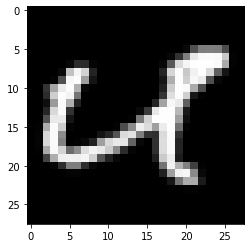

2


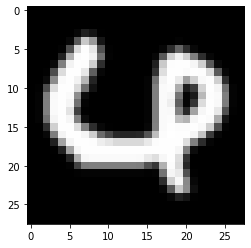

2


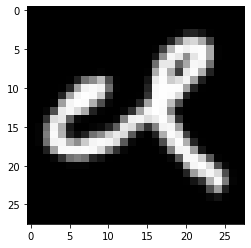

2


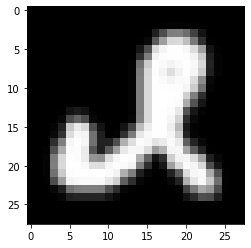

2


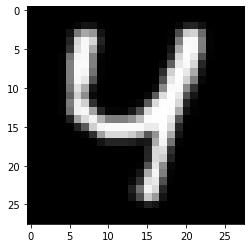

2


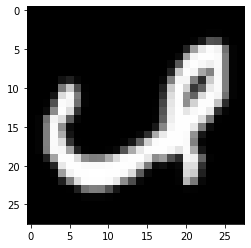

2


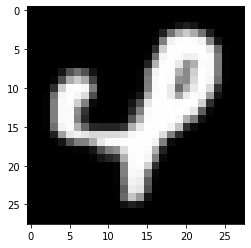

2


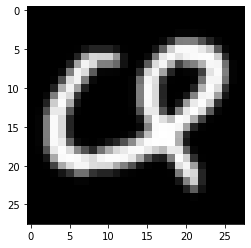

2


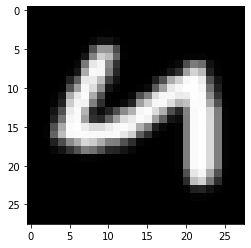

2


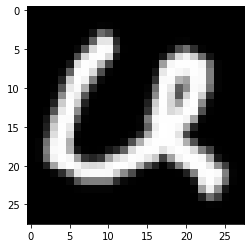

In [0]:
#查看数量是否有误
# num1 = 0
# num2 = 0
# for j in range(NUM_CLIENTS):
#   #print("pixels",len(pixels[j]))
#   num1 = num1 + len(pixels[j])
#   num2 = num2 + len(label[j])
#   #print("label",label[j])
# print(num1)
# print(num2)

#查看某个客户端每个类别分别有多少
def num_per_class(label):
  num = np.zeros(shape=(10), dtype='int32')
  for i in range (len(label)):
    l = label[i]
    num[l] = num[l] + 1
  return num

# for i in range(NUM_CLIENTS):
#   print(num_per_label(label[i]))

#print(num)


#随机画图看是否有误:无误
#把图片画出来看一看
a = 9
for i in range(10):
  print(f2["examples"][client_ids[a]]["label"].value[i])
  plt.imshow(f2["examples"][client_ids[a]]["pixels"].value[i],cmap='gray')
  plt.grid(False)
  plt.show()

In [0]:
#数据集构造完成以后，调用内存清理操作
del bal2_balance_class[:]
del pixels[:]
del label[:]
gc.collect()

0

### 构造BAL3数据集：全局平衡，标量不平衡，局部Non-IID

In [0]:
'''
构造BAL3数据集
全局平衡：10个label，每个label6000张图片
标量不平衡，局部Non-IID
客户端：100，C=0.02
60000张图片随机分给100个用户:感觉有点平衡
最后采用碎片式，按照label分成很多个碎片，CHIP_SIZE控制碎片大小
'''

In [0]:
#获得全局绝对平衡数据集
bal3_balance_class = [[]for i in range(10)]  
for i in range(0,10):
  bal3_balance_class[i] = class_[i][0:6000]

In [0]:
#删除一个h5py文件
f3.flush()
f3.clear()

In [0]:
#创建hdf5文件
f3 = h5py.File("/content/drive/My Drive/Colab Notebooks/BAL3.hdf5","a")
#f3 = h5py.File("BAL3.hdf5","a")
#创建顶层group
top_group = f3.create_group("examples")

In [0]:
#创建BAL3
#将60000张图片随机分给100个客户端

NUM_CLIENTS = 100  
NUM_CLASS = 10
NUM_PER_CLASS = 600
CHIP_SIZE = 100
NUM_CHIP = NUM_CLASS * NUM_PER_CLASS // CHIP_SIZE

#pixels[i]存放的是第i个客户端的图片，label[i]以此类推
pixels = [[]for i in range(NUM_CLIENTS)]
label = [[]for i in range(NUM_CLIENTS)]
client_ids = []
for i in range(NUM_CLASS):  #外层循环控制类别
  for j in range(NUM_CHIP):  #每个类循环碎片个数次
    #随机选择一个客户端并把本次的碎片放进去
    random_client_id = random.randint(0, NUM_CLIENTS-1)
    #本次碎片的开始下标，从该下标开始往后最多CHIP_SIZE个样本为本次碎片
    start = j*CHIP_SIZE
    for k in range(min(CHIP_SIZE, len(bal3_balance_class[i])-start)):
      pixels[random_client_id].append(bal3_balance_class[i][start+k]/255.0)
      label[random_client_id].append(i)
    
#将pixels和label加入对应client的group中
for i in range(NUM_CLIENTS):
  client_ids.append("f00_" + str(i))
  temp_group = top_group.create_group(name="f00_" + str(i))
  label_ds = temp_group.create_dataset(name="label", data=np.array(label[i], dtype='int32'))
  pixels_ds = temp_group.create_dataset(name="pixels", data=np.array(pixels[i], dtype='float32'))
  print(len(label[i]))
  print(num_per_class(label[i]))

200
[200   0   0   0   0   0   0   0   0   0]
400
[  0 200   0   0   0   0   0 200   0   0]
900
[200 100   0 200 100 100 100 100   0   0]
800
[100   0 100 100 300   0 100   0   0 100]
700
[100 100 100 100 100   0   0 100   0 100]
600
[  0 100   0   0   0 300 100   0 100   0]
600
[100   0 100 200   0   0 100 100   0   0]
1000
[100 200 100   0   0 100 100 100 100 200]
800
[  0   0 200 100   0 200   0 100 200   0]
600
[100 100   0   0 100 100 100   0   0 100]
600
[  0   0 200   0 100   0 100   0 100 100]
400
[  0   0 100 200   0   0 100   0   0   0]
700
[100   0 100   0   0   0 100 300 100   0]
1000
[  0 100 100   0 300   0 200   0 100 200]
600
[  0 100   0   0 100 100   0   0 200 100]
400
[  0 200   0   0 100   0 100   0   0   0]
500
[100   0 100 100 100   0   0   0 100   0]
900
[200 100 400   0   0   0   0   0 100 100]
600
[  0 100 100   0   0   0   0 100 100 200]
400
[  0 100   0 100   0   0   0   0 200   0]
500
[100   0   0   0 200   0 100 100   0   0]
600
[  0 200 100 100   0 100 100

0


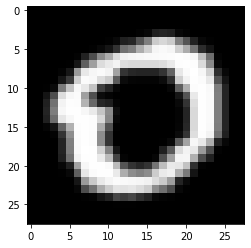

0


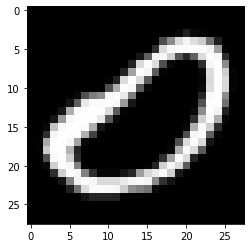

0


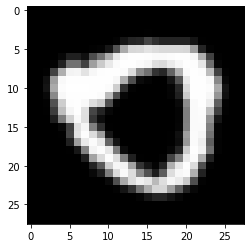

0


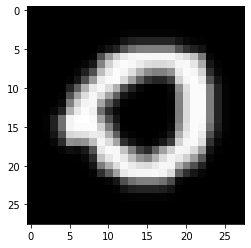

0


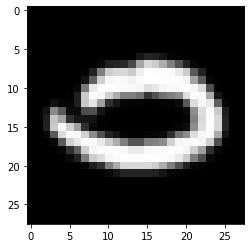

0


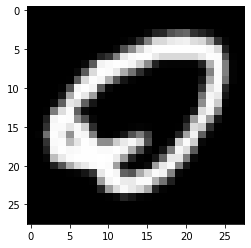

0


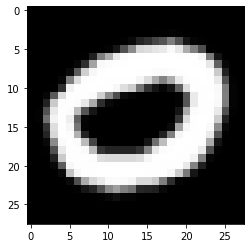

0


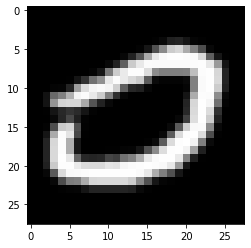

0


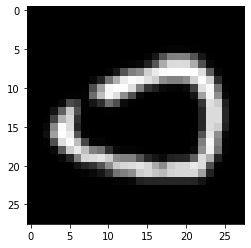

0


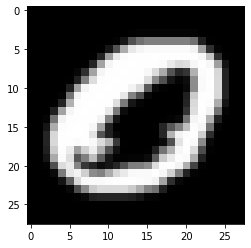

In [0]:
# #查看总的数量是否有误:无误
# num1 = 0
# num2 = 0
# for j in range(5):
#   #print("pixels",len(pixels[j]))
#   num1 = num1 + len(pixels[j])
#   num2 = num2 + len(label[j])
#   #print("label",label[j])
# print(num1)
# print(num2)

len(f3["examples"][client_ids[2]]["label"].value)
# print(f3["examples"][client_ids[3]]["label"].value[699])
# plt.imshow(f3["examples"][client_ids[3]]["pixels"].value[699], cmap='gray', aspect='equal')
# plt.grid(False)
# #这里这个画应该是一种很随意的，因为不想再用所以命名就是_
# #plt.imshow（）负责对图像进行处理并调整其格式但是不能显示，必须在其后跟着plt.show()才能成功显示出来
# _=plt.show()

#随机画图看是否有误:无误
#把图片画出来看一看
for i in range(10):
  print(f3["examples"][client_ids[3]]["label"].value[i])
  plt.imshow(f3["examples"][client_ids[3]]["pixels"].value[i],cmap='gray')
  plt.grid(False)
  plt.show()

In [0]:
#数据集构造完成以后，调用内存清理操作
del pixels[:]
del label[:]
del bal3_balance_class[:]
gc.collect()

23374

### 构造BAL4数据集，全局不平衡，标量不平衡，局部Non-IID

In [0]:
'''
BAL4：标量不平衡，全局不平衡，局部不平衡
使用原始的mnist
60000张图片随机分给100个客户端，每个客户端数目不固定
整体设置为病态不平衡，标量从40-220不等，局部Non-IID也非常病态
由CHIP控制不平衡程度，全局不平衡比例由人为：
10:10:5:5:2:8:7:3:4:6
'''

In [0]:
#获取总的数据集：最开始使用了洗牌算法，后来发现随机的还是有点平衡，最后改用认为控制类别比例
#因为需要使用删除操作所以不能直接使用=赋值

# copy_y_train = []
# copy_x_train = []
# x_class = []
# y_class = []
# for i in range(len(x_train_emnist_digits)):
#   copy_y_train.append(y_train_emnist_digits[i])
#   copy_x_train.append(x_train_emnist_digits[i])

# for i in range(60000):
#   #因为只使用一个随机数产生的还是有点均匀，我决定去网上寻找非均匀的分布
#   start = random.randint(0,len(copy_y_train)//2)
#   #随机产生一个下标
#   random_index = random.randint(0,len(copy_y_train)-1)
#   label_val = copy_y_train[random_index]
  
#   x_class.append(copy_x_train[random_index])
#   y_class.append(label_val)
  
#   del copy_y_train[random_index]
#   del copy_x_train[random_index]

#获得全局不平衡数据集，各个类别之间的比例由我指定，以免随机分配太平衡
ratio = [10,10,5,5,2,8,7,3,4,6]
bal4_imbalance_class = [[]for i in range(10)]  
for i in range(0,10):
  end = tf.cast(ratio[i]/sum(ratio) * 60000, tf.int32)
  
  bal4_imbalance_class[i] = class_[i][0:end]

In [0]:
#因为构造的数据集有误，所以需要看总的图片是否有误
#第一次查看：有误.第二次查看：有误

# for i in range(10,20):
#   print(y_class[i])
#   plt.imshow(x_class[i], cmap='gray', aspect='equal')
#   plt.grid(False)
#   _=plt.show()
#统计每个类别有多少张图片:[5926 5953 5999 6027 5935 6089 5980 5885 6088 6118]:太均匀了
#新产生的每个类别图片数：[10000, 10000, 5000, 5000, 2000, 8000, 7000, 3000, 4000, 6000]

print([len(bal4_imbalance_class[i]) for i in range(10)])


[10000, 10000, 5000, 5000, 2000, 8000, 7000, 3000, 4000, 6000]


In [0]:
#删除一个h5py文件
f4.flush()
f4.clear()

In [0]:
#创建hdf5文件
f4 = h5py.File("/content/drive/My Drive/Colab Notebooks/BAL4.hdf5","a")
#创建顶层group
top_group = f4.create_group("examples")

In [0]:
#创建BAL4
#将60000张图片随机分给100个客户端，为了达到病态的效果，以CHIP_SIZE张图片为一个碎片，将碎片随机分给100个客户端

NUM_CLIENTS = 100 
NUM_CLASS = 10
#NUM_PER_CLASS = 600
CHIP_SIZE = 100
NUM_CHIP = NUM_CLASS * NUM_PER_CLASS // CHIP_SIZE

pixels = [[]for i in range(NUM_CLIENTS)]
label = [[]for i in range(NUM_CLIENTS)]
client_ids = []
for i in range(NUM_CLASS):  #循环10*6000
  for j in range(len(bal4_imbalance_class[i])//CHIP_SIZE):
    random_client_id = random.randint(0, NUM_CLIENTS-1)
    start = j*CHIP_SIZE
    for k in range(min(CHIP_SIZE, len(bal4_imbalance_class[i])-start)):
      pixels[random_client_id].append(bal4_imbalance_class[i][start+k]/255.0)
      label[random_client_id].append(i)
    
#将pixels和label加入对应client的group中
num = 0
for i in range(NUM_CLIENTS):
  client_ids.append("f00_" + str(i))
  temp_group = top_group.create_group(name="f00_" + str(i))
  label_ds = temp_group.create_dataset(name="label", data=np.array(label[i], dtype='int32'))
  pixels_ds = temp_group.create_dataset(name="pixels", data=np.array(pixels[i], dtype='float32'))
  print(len(label[i]))
  print(num_per_class(label[i]))
  num = num + len(label[i])
#统计最终分给100个客户端的样本总数是多少  
print(num)

600
[  0 100 100   0   0   0 200 100   0 100]
300
[  0   0   0   0   0 100   0   0 100 100]
900
[300 100 100   0   0 100 100 100   0 100]
500
[  0   0 100 100   0   0   0 200   0 100]
700
[200 300   0   0   0 100   0   0   0 100]
400
[100   0   0 100   0   0 100 100   0   0]
500
[  0   0 100 100   0 200   0   0   0 100]
800
[  0 200   0 100   0 100 100   0 100 200]
900
[300 200   0 100   0 100   0   0   0 200]
800
[100   0 100 200   0 100 100   0   0 200]
300
[  0 100   0   0   0 100 100   0   0   0]
600
[100 200 200   0   0 100   0   0   0   0]
1000
[100 300   0   0   0 100 200 100   0 200]
400
[100 100   0 100   0   0 100   0   0   0]
400
[  0 100 100   0   0   0 200   0   0   0]
900
[100 300   0 100   0 100   0   0 100 200]
900
[100   0 100   0 100 100 300 200   0   0]
800
[100 100 100   0   0 100   0 200 100 100]
600
[300   0   0   0   0   0 100 100 100   0]
700
[100 200   0   0 200 100 100   0   0   0]
700
[100 100   0 100   0   0 300   0 100   0]
900
[500 100   0   0 100 100   0 

In [0]:
#查看数量是否有误
num1 = 0
num2 = 0
for j in range(5):
  #print("pixels",len(pixels[j]))
  num1 = num1 + len(pixels[j])
  num2 = num2 + len(label[j])
  #print("label",label[j])
print(num1)
# # print(num2)

#随机画图看是否有误:第一次有误，label和图片对不上
#把图片画出来看一看
# for i in range(10):
#   print(f3["examples"][client_ids[3]]["label"].value[i])
#   plt.imshow(f3["examples"][client_ids[3]]["pixels"].value[i],cmap='gray')
#   plt.grid(False)
#   plt.show()

3000


In [0]:
#数据集构造完成以后，调用内存清理操作
del pixels[:]
del label[:]
del bal4_imbalance_class[:]
gc.collect()

165

### 关闭文件操作

In [0]:
f_t.close()
f1.close()
f2.close()
f3.close()
f4.close()

### 各个数据集实例化

In [0]:
#实例化构造的数据集:test
test = tff.simulation.hdf5_client_data.HDF5ClientData("/content/drive/My Drive/Colab Notebooks/test.hdf5")
num_clients_test = len(test.client_ids)
print(num_clients_test)

50


In [0]:
#实例化构造的数据集：BAL1
BAL1 = tff.simulation.hdf5_client_data.HDF5ClientData("/content/drive/My Drive/Colab Notebooks/BAL1.hdf5")
num_clients_BAL1 = len(BAL1.client_ids)
print(num_clients_BAL1)
#留出总客户端的4分之一做测试集
#BAL1_train, BAL1_test = BAL1.train_test_client_split(client_data=BAL1, num_test_clients= num_clients_BAL1//4)

100


In [218]:
#实例化构造的数据集：BAL2
BAL2 = tff.simulation.hdf5_client_data.HDF5ClientData("/content/drive/My Drive/Colab Notebooks/BAL2.hdf5")
num_clients_BAL2 = len(BAL2.client_ids)
print(num_clients_BAL2)
#留出总客户端的4分之一做测试集
#BAL2_train, BAL2_test = BAL2.train_test_client_split(client_data=BAL2, num_test_clients= num_clients_BAL2//4)

100


['f00_0', 'f00_1', 'f00_10', 'f00_11', 'f00_12', 'f00_13', 'f00_14', 'f00_15', 'f00_16', 'f00_17', 'f00_18', 'f00_19', 'f00_2', 'f00_20', 'f00_21', 'f00_22', 'f00_23', 'f00_24', 'f00_25', 'f00_26']
[  0   0 200   0 100   0 100   0 100 100]
9


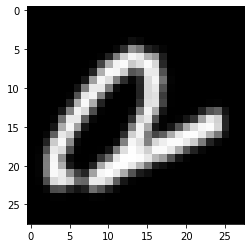

In [0]:
#实例化构造的数据集：BAL3
BAL3 = tff.simulation.hdf5_client_data.HDF5ClientData("/content/drive/My Drive/Colab Notebooks/BAL3.hdf5")
num_clients_BAL3 = len(BAL3.client_ids)
#print(num_clients_BAL3)

#使用了迭代器发现确实BAL3里面的客户端样本数和分配给它的不一样
example_dataset = BAL3.create_tf_dataset_for_client(
    BAL3.client_ids[2]
)
example_element = next(iter(example_dataset))

print(BAL3.client_ids[0:20])

#调查，第2个客户端只分配了300个样本，但是用迭代器迭代出来了600个样本,全部都可以实例化
#第3个客户端分配了700个样本，迭代器迭代出来了600个
n = 0
l = []
iter_ = iter(example_dataset)
while(n < 600):
  example_element = next(iter_)
  n = n+1
  l.append(example_element['label'].numpy() )
  #print(n)

print(num_per_class(l))
print(example_element['label'].numpy() )
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
#这里这个画应该是一种很随意的，因为不想再用所以命名就是_
#plt.imshow（）负责对图像进行处理并调整其格式但是不能显示，必须在其后跟着plt.show()才能成功显示出来
_=plt.show()

In [0]:
#实例化构造的数据集：BAL4
BAL4 = tff.simulation.hdf5_client_data.HDF5ClientData("/content/drive/My Drive/Colab Notebooks/BAL4.hdf5")
num_clients_BAL4 = len(BAL4.client_ids)
print(num_clients_BAL4)
example_dataset = BAL4.create_tf_dataset_for_client(
    BAL4.client_ids[4]
)
example_element = next(iter(example_dataset))

print(BAL4.client_ids[0:20])

#调查，第2个客户端只分配了300个样本，但是用迭代器迭代出来了600个样本,全部都可以实例化
#第3个客户端分配了700个样本，迭代器迭代出来了600个
n = 0
l = []
iter_ = iter(example_dataset)
#计算有多少个样本
while(n < 1000):
  example_element = next(iter_)
  n = n+1
  l.append(example_element['label'].numpy() )
  #print(n)
# #计算样本分布
# while(iter_):
#   example_element = next(iter_)
#   n = n+1
#   l.append(example_element['label'].numpy() )
#   print(n)
print(num_per_class(l))
# print(example_element['label'].numpy() )
# plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
# plt.grid(False)
# #这里这个画应该是一种很随意的，因为不想再用所以命名就是_
# #plt.imshow（）负责对图像进行处理并调整其格式但是不能显示，必须在其后跟着plt.show()才能成功显示出来
# _=plt.show()

100
['f00_0', 'f00_1', 'f00_10', 'f00_11', 'f00_12', 'f00_13', 'f00_14', 'f00_15', 'f00_16', 'f00_17', 'f00_18', 'f00_19', 'f00_2', 'f00_20', 'f00_21', 'f00_22', 'f00_23', 'f00_24', 'f00_25', 'f00_26']
[100 300   0   0   0 100 200 100   0 200]


In [0]:
print(len(test.client_ids))

50


In [0]:
#BAL1.client_ids
#这里面的每一个打印出来都是和example_dataset类型一样的
x = tf.data.Dataset.from_tensor_slices(
        collections.OrderedDict((name, ds.value) for name, ds in sorted(
            f1["examples"][BAL1.client_ids[0]].items())))
print(x)
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0]
)
print(example_dataset)

<TensorSliceDataset shapes: OrderedDict([(label, ()), (pixels, (28, 28))]), types: OrderedDict([(label, tf.int32), (pixels, tf.float32)])>
<TensorSliceDataset shapes: OrderedDict([(label, ()), (pixels, (28, 28))]), types: OrderedDict([(label, tf.int32), (pixels, tf.float32)])>


In [0]:
#此处得到客户端的总数K，因为每一轮随机选择C×K的向上取整
#根据FedAvg做的研究C取0.2可获得较好的性能，为了简化模型K这里取固定的数
# K = len(emnist_train.client_ids)
#BAL1数据集
K = len(BAL4.client_ids)
C = 0.02
math.ceil(K*C)

8

0


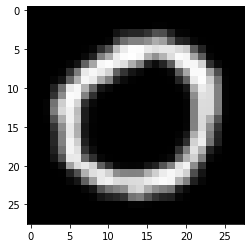

In [0]:
#这个单元格在看数据集里面的图片是否正常
#第一次：test的label和图片匹配不上
example_dataset = BAL1.create_tf_dataset_for_client(
    BAL1.client_ids[3]
)

example_element = next(iter(example_dataset))
print(example_element['label'].numpy())  #加了.numpy（）是在取numpy()属性的值，就是用.取属性值的意思

from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_=plt.show()

### 图像预处理

In [0]:
#NUM_CLIENTS在实验的时候应该是K×C,375*0.2=75
#NUM_CLIENTS = math.ceil(K*C)
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

#预处理，将图片中的‘pixels'、‘label'分别表示成x和y
#将28×28的图像展平成784个元素，打乱顺序
def preprocess(dataset):
  #内部函数将像素和标签转换成x和y，并将像素展平
  def batch_format_fn(element):
    return collections.OrderedDict(
        #因为是灰度图所以通道数为1，如果是rgb图片则为3
        #因为CNN卷积层接收一个4d向量
        x = tf.reshape(element['pixels'], [-1,28,28,1]),
        y = tf.reshape(element['label'], [-1,1])
    )
  
  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [0]:
#为指定用户创建联邦数据,接收训练集和用户id
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
    ]


In [0]:
#这里改成随机获得NUM_CLIENTS个用户，模拟联邦学习每轮的随机选择用户
# sample_clients = random.sample(emnist_train.client_ids, NUM_CLIENTS)
# federated_train_data = make_federated_data(emnist_train, sample_clients)
example_dataset = BAL1.create_tf_dataset_for_client(
    BAL1.client_ids[0]
)
print("examle_dataset",example_dataset)

#BAL1数据集测试
#sample_clients = random.sample(BAL1.client_ids, NUM_CLIENTS)
sample_clients = BAL1.client_ids[0:NUM_CLIENTS]
federated_train_data = make_federated_data(BAL1, sample_clients)

#BAL2数据集测试
sample_clients = BAL1.client_ids[0:NUM_CLIENTS]
federated_train_data = make_federated_data(BAL1, sample_clients)

examle_dataset <TensorSliceDataset shapes: OrderedDict([(label, ()), (pixels, (28, 28))]), types: OrderedDict([(label, tf.int32), (pixels, tf.float32)])>


### 原使用class的模型部分

In [0]:
'''
#！自己添加代码中，正在想办法把训练模型改成CNN
class CNN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=32,             # 卷积层神经元（卷积核）数目
            kernel_size=[5, 5],     # 感受野大小
            padding='same',         # padding策略（vaild 或 same）
            activation=tf.nn.relu   # 激活函数
        )
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.conv2 = tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=[5, 5],
            padding='same',
            activation=tf.nn.relu
        )
        #print("kernel:",kernel_size)
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.flatten = tf.keras.layers.Reshape(target_shape=(7 * 7 * 64,))
        self.dense1 = tf.keras.layers.Dense(units=1024, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=10)
 
    def call(self, inputs):
        x = self.conv1(inputs)                  # [batch_size, 28, 28, 32]
        x = self.pool1(x)                       # [batch_size, 14, 14, 32]
        x = self.conv2(x)                       # [batch_size, 14, 14, 64]
        x = self.pool2(x)                       # [batch_size, 7, 7, 64]
        x = self.flatten(x)                     # [batch_size, 7 * 7 * 64]
        x = self.dense1(x)                      # [batch_size, 1024]
        x = self.dense2(x)
        #tf.nn.softmax()将原始输出归一化，且能凸显原始向量中最大的值                      # [batch_size, 10]
        output = tf.nn.softmax(x)
        return output
        '''


### 模型定义部分


In [0]:
#创建一个变量集合来表示所有变量,包括model(weights+bias)以及metrics(num_examples,loss_sum,accuracy_sum)
MnistVariables = collections.namedtuple(
    'MnistVariables','cnn_conv2d_kernel cnn_conv2d_bias cnn_conv2d_1_kernel cnn_conv2d_1_bias cnn_dense_kernel cnn_dense_bias cnn_dense_1_kernel cnn_dense_1_bias num_examples loss_sum accuracy_sum'
)

In [0]:
#创建变量并初始化
def create_mnist_variables():
  #核初始化函数，使用正态分布，先使用tf.XXX(初始参数)生成一个模型关键字C，再使用C(arg1)传参数进去
  kernel_initalizer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05)
  return MnistVariables(
      #第一层卷积在5×5的patch中算出32个特征，权重张量形状为[5,5,1,32]
      #前两个维度是patch的大小，接着是输入的通道数，最后是输出的通道数目
      #h_conv1.shape=[-1,28,28,32]，第一个pooling层将其变成[-1,14,14,32]     
      cnn_conv2d_kernel=tf.Variable(
          #权重初始化至关重要，不能全部初始化为0！！！
          initial_value=kernel_initalizer(shape=(5,5,1,32), dtype=tf.float32),
          name='cnn_conv2d_kernel',
          trainable=True),
      #32个输出通道，每个输出通道都有一个对应的偏置
      cnn_conv2d_bias=tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(32,)),
          name='cnn_conv2d_bias',
          trainable=True),
      #第二层卷积,64个过滤器，共享权重矩阵为32*5*5,h_conv2.shape=[-1,14,14,64]
      #第二个pooling层将其变成[-1,7,7,64]
      cnn_conv2d_1_kernel=tf.Variable(
          initial_value=kernel_initalizer(shape=(5,5,32,64), dtype=tf.float32),
          name='cnn_conv2d_1_kernel',
          trainable=True),
      #64个输出通道对应64个偏置
      cnn_conv2d_1_bias=tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(64,)),
          name='cnn_conv2d_1_bias',
          trainable=True),
      #全连接层，现在图片尺寸减小到7×7，加入一个有1024个神经元的全连接层用于处理整个图片
      #将池化层输出的张量reshape成一些7*7*64的向量，乘上权重加上偏置然后使用ReLU
      cnn_dense_kernel=tf.Variable(
          initial_value=kernel_initalizer(shape=(7*7*64,1024), dtype=tf.float32),
          name='cnn_dense_kernel',
          trainable=True),
      cnn_dense_bias=tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(1024,)),
          name='cnn_dense_bias',
          trainable=True),
      #这里以后可以加一个Dropout
      cnn_dense_1_kernel=tf.Variable(
          initial_value=kernel_initalizer(shape=(1024,10), dtype=tf.float32),
          name='cnn_dense_1_kernel',
          trainable=True),
      cnn_dense_1_bias=tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(10,)),
          name='cnn_dense_1_bias',
          trainable=True),
      num_examples=tf.Variable(0.0, name='num_examples', trainable=False),
      loss_sum=tf.Variable(0.0, name='loss_sum', trainable=False),
      accuracy_sum=tf.Variable(0.0, name='accuracy_sum', trainable=False)
  )

In [0]:
#自定义前向传播函数
def mnist_forward_pass(variables, batch):
  _input_ = batch['x']  #取训练图片

  #神经网络
  #第一层卷积
  conv = tf.nn.conv2d(_input_, variables.cnn_conv2d_kernel, strides=[1,1,1,1], padding='SAME')                  # [batch_size, 28, 28, 32]
  pre_activation = tf.nn.bias_add(conv, variables.cnn_conv2d_bias)
  conv1 = tf.nn.relu(pre_activation, name='conv1')

  #第一层卷积层的池化
  pool1 = tf.nn.max_pool2d(conv1, ksize=[2, 2], strides=2, padding='SAME')

  #第二层卷积
  conv = tf.nn.conv2d(pool1, variables.cnn_conv2d_1_kernel, strides=[1,1,1,1], padding='SAME')
  pre_activation = tf.nn.bias_add(conv, variables.cnn_conv2d_1_bias)
  conv2 = tf.nn.relu(pre_activation, name='conv2')

  #第二层卷积的池化
  pool2 = tf.nn.max_pool2d(conv2, ksize=[2,2], strides=2, padding='SAME')
  print("pool2",pool2)
  
  #flatten
  flatten = tf.reshape(pool2, shape=(-1,7*7*64))
  print("flatten over")

  #全连接层1
  dense1 = tf.nn.relu(tf.matmul(flatten, variables.cnn_dense_kernel) + variables.cnn_dense_bias)
  print("dense1 over")

  #添加一个Dropout防止过拟合
  #keep_drop = tf.placeholder(tf.float32)
  #drop_dense1 = tf.nn.tropout(dense1, variables.keep_drop)

  #全连接层2
  dense2 = tf.matmul(dense1, variables.cnn_dense_1_kernel) + variables.cnn_dense_1_bias
  print("dense2 over")

  y_pred = tf.nn.softmax(dense2)
  print("y_pred",y_pred)

  #计算损失
  flat_labels = tf.reshape(batch['y'], [-1])
  loss = -tf.reduce_mean(
      tf.reduce_sum(tf.one_hot(flat_labels, 10) * tf.math.log(y_pred), axis=[1]))
  
  
  #计算准确率
  predictions = tf.cast(tf.argmax(y_pred,1), tf.int32)
  accuracy = tf.reduce_mean(
      tf.cast(tf.equal(predictions, flat_labels), tf.float32))
  
  #样本数
  num_examples = tf.cast(tf.size(batch['y']), tf.float32)

  #更新样本数、损失和、精度和,每一批都考虑了自己的权重
  variables.num_examples.assign_add(num_examples)
  variables.loss_sum.assign_add(loss * num_examples)
  variables.accuracy_sum.assign_add(accuracy * num_examples)

  
  return loss, predictions

In [0]:
#计算本地用户的metrics度量
def get_local_mnist_metrics(variables):
  return collections.OrderedDict(
      num_examples=variables.num_examples,
      loss=variables.loss_sum / variables.num_examples,
      accuracy=variables.accuracy_sum / variables.num_examples
  )

In [0]:
#集合每个设备发出的本地度量
@tff.federated_computation
def aggregate_mnist_metrics_across_clients(metrics):
  return collections.OrderedDict(
      num_examples=tff.federated_sum(metrics.num_examples),
      loss=tff.federated_mean(metrics.loss, metrics.num_examples),
      accuracy=tff.federated_mean(metrics.accuracy, metrics.num_examples)
  )

In [0]:
#自定义模型，创建tff.learning.model实例
class MnistModel(tff.learning.Model):

  def __init__(self):
    self._variables = create_mnist_variables()

  #所有的“tf.Variables”都应该在“__init__”中引入
  @property
  def trainable_variables(self):
    #return [self._variables.weights, self._variables.bias]
    return [self._variables.cnn_conv2d_kernel,
        self._variables.cnn_conv2d_bias,
        self._variables.cnn_conv2d_1_kernel,
        self._variables.cnn_conv2d_1_bias,
        self._variables.cnn_dense_kernel,
        self._variables.cnn_dense_bias,
        self._variables.cnn_dense_1_kernel,
        self._variables.cnn_dense_1_bias
        ]
  
  @property
  def non_trainable_variables(self):
    return []
  
  @property
  def local_variables(self):
    return [self._variables.num_examples, self._variables.loss_sum,
         self._variables.accuracy_sum]
  
  @property
  def input_spec(self):
    return collections.OrderedDict(
        x=tf.TensorSpec([None, 28,28,1], tf.float32),
        y=tf.TensorSpec([None, 1], tf.int32)
    )

  @tf.function
  def forward_pass(self, batch, training=True):
    del training
    loss, predictions = mnist_forward_pass(self._variables, batch)
    #取出样本数
    num_examples = tf.shape(batch['x'])[0]
    return tff.learning.BatchOutput(
        loss=loss, predictions=predictions, num_examples=num_examples)
    
  @tf.function
  def report_local_outputs(self):
    return get_local_mnist_metrics(self._variables)
  
  @property
  def federated_output_computation(self):
    return aggregate_mnist_metrics_across_clients

In [0]:
#创建迭代器执行联合平均的迭代过程
iterative_process = tff.learning.build_federated_averaging_process(
    MnistModel,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02)
)

### 模型训练部分

In [0]:
#获得初始状态
state = iterative_process.initialize()

In [0]:
#NUM_CLIENTS_PER_ROUND = math.ceil(K * C)
NUM_CLIENTS = 50
NUM_CLIENTS_PER_ROUND = 5
#查看第一轮训练
# sample_clients = random.sample(emnist_train.client_ids, NUM_CLIENTS)
# federated_train_data = make_federated_data(emnist_train, sample_clients)
#BAL1数据集测试
#sample_clients = random.sample(BAL1.client_ids, NUM_CLIENTS_PER_ROUND)
# sample_clients = BAL1.client_ids[0:NUM_CLIENTS_PER_ROUND]
# federated_train_data = make_federated_data(BAL1, sample_clients)

#BAL2数据集测试
# sample_clients = random.sample(BAL2.client_ids, NUM_CLIENTS_PER_ROUND)
# sample_clients = BAL2.client_ids[0:NUM_CLIENTS_PER_ROUND]
# federated_train_data = make_federated_data(BAL2, sample_clients)

# #BAL3数据集测试
# sample_clients = random.sample(BAL3.client_ids, NUM_CLIENTS_PER_ROUND)
# sample_clients = BAL3.client_ids[0:5]
# federated_train_data = make_federated_data(BAL3, sample_clients)


#BAL4数据集测试
# sample_clients = random.sample(BAL4.client_ids, NUM_CLIENTS_PER_ROUND)
sample_clients = BAL4.client_ids[0:5]
federated_train_data = make_federated_data(BAL4, sample_clients)

state, metrics = iterative_process.next(state, federated_train_data)
print('round 1, metrics={}'.format(metrics))

round 1, metrics=<num_examples=14000.0,loss=0.012825774028897285,accuracy=0.9966428279876709>


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [220]:
#计算更多轮
NUM_ROUNDS = 20
NUM_CLIENTS = 100
NUM_CLIENTS_PER_ROUND = 5
for round_num in range(NUM_ROUNDS):
  #随机选择NUM_CLIENTS个用户
  # sample_clients = random.sample(emnist_train.client_ids, NUM_CLIENTS_PER_ROUND)
  # federated_train_data = make_federated_data(emnist_train, sample_clients)
  
  # #BAL1数据集测试:先使用使用轮询的方式，不使用随机数
  # sample_clients = random.sample(BAL1.client_ids, NUM_CLIENTS_PER_ROUND)
  # sample_clients = BAL1.client_ids[NUM_CLIENTS_PER_ROUND*round_num:NUM_CLIENTS_PER_ROUND*(round_num+1)]
  # federated_train_data = make_federated_data(BAL1, sample_clients)

  # #BAL2数据集测试
  # sample_clients = random.sample(BAL2.client_ids, NUM_CLIENTS_PER_ROUND)
  # sample_clients = BAL2.client_ids[NUM_CLIENTS_PER_ROUND*round_num:NUM_CLIENTS_PER_ROUND*(round_num+1)]
  # federated_train_data = make_federated_data(BAL2, sample_clients)

  # #BAL3数据集测试
  # sample_clients = random.sample(BAL3.client_ids, NUM_CLIENTS_PER_ROUND)
  sample_clients = BAL3.client_ids[NUM_CLIENTS_PER_ROUND*round_num:NUM_CLIENTS_PER_ROUND*(round_num+1)]
  federated_train_data = make_federated_data(BAL3, sample_clients)

  #BAL4数据集测试
  # sample_clients = random.sample(BAL4.client_ids, NUM_CLIENTS_PER_ROUND)
  # sample_clients = BAL4.client_ids[NUM_CLIENTS_PER_ROUND*round_num:NUM_CLIENTS_PER_ROUND*(round_num+1)]
  # federated_train_data = make_federated_data(BAL4, sample_clients)

  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num+1, metrics))

round  1, metrics=<num_examples=11500.0,loss=0.36519351601600647,accuracy=0.8882608413696289>
round  2, metrics=<num_examples=17000.0,loss=0.25333237648010254,accuracy=0.9268823266029358>
round  3, metrics=<num_examples=15000.0,loss=0.15479391813278198,accuracy=0.956933319568634>
round  4, metrics=<num_examples=13000.0,loss=0.09372705966234207,accuracy=0.9715384840965271>
round  5, metrics=<num_examples=15500.0,loss=0.08884578198194504,accuracy=0.9732258319854736>
round  6, metrics=<num_examples=14500.0,loss=0.06892509013414383,accuracy=0.9795172214508057>
round  7, metrics=<num_examples=16500.0,loss=0.08760654926300049,accuracy=0.9747272729873657>
round  8, metrics=<num_examples=14000.0,loss=0.05005074292421341,accuracy=0.9837142825126648>
round  9, metrics=<num_examples=10000.0,loss=0.05268795043230057,accuracy=0.9830999970436096>
round 10, metrics=<num_examples=18000.0,loss=0.05652870610356331,accuracy=0.9847777485847473>
round 11, metrics=<num_examples=15000.0,loss=0.03424808382987

### 使用TensorBoard可视化

In [0]:
'''
#使用tensorboard可视化
#使用Tensorboard可视化这些联邦计算的度量
#创建目录和相应的摘要编写器
#@test {"skip": true}
logdir = "/tmp/logs/scalars/training/"
summary_writer = tf.summary.create_file_writer(logdir)
state = iterative_process.initialize()

#!!!太坑了，我以为@test是无关紧要的东西，emmm，就省略了，没想到就凉凉
#@test {"skip": true}
with summary_writer.as_default():
  for round_num in range(1, NUM_ROUNDS):
    #随机选择用户
    sample_clients = random.sample(emnist_train.client_ids, NUM_CLIENTS)
    federated_train_data = make_federated_data(emnist_train, sample_clients)

    state, metrics = iterative_process.next(state, federated_train_data)

    print('round {:2d}, metrics={}'.format(round_num, metrics))

    for name, value in metrics._asdict().items():
      tf.summary.scalar(name, value, step=round_num)
'''

In [0]:
'''
#这个tensorBoard像有猫病一样，昨天还可以今天来突然就不行了
#@test {"skip":true}
%load_ext tensorboard
%tensorboard --logdir /tmp/logs/scalars/ --port=0
'''

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2020-04-06 08:24:12.865933: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2020-04-06 08:24:12.866088: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2020-04-06 08:24:12.866105: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, 

### 在测试集上评估

In [221]:
#在测试集上进行测试
#求值传递MnistModel就足够了，不执行梯度下降，也不需要构造优化器，MnistTModel就是前面定义的那个class
evaluation = tff.learning.build_federated_evaluation(MnistModel)

pool2 Tensor("MaxPool2d_1:0", shape=(None, 7, 7, 64), dtype=float32)
flatten over
dense1 over
dense2 over
y_pred Tensor("Softmax:0", shape=(None, 10), dtype=float32)


In [0]:
#评估一下在训练中得到的最新状态，为了从服务器状态中提取最新的训练模型，只需访问.model成员
#和上面说的形式一样，它接收model和联邦数据并返回训练的metrics
#这里是在评估模型的最新状态，为了从服务器状态中提取最新的训练模型，只需访问.model成员
#train_metrics = evaluation(state.model, federated_train_data)

In [222]:
#编译联邦数据的测试样本，并对测试数据重新运行求值。同样也是随机选择NUM_CLIENTS个用户。
# sample_clients = random.sample(emnist_train.client_ids, NUM_CLIENTS_PER_ROUND)
# federated_test_data = make_federated_data(emnist_test, sample_clients)
NUM_TEST_CLIENTS = len(test.client_ids)

#测试集测试精度
# sample_clients = random.sample(BAL4_test.client_ids, NUM_CLIENTS_PER_ROUND)
sample_clients = test.client_ids[0:NUM_TEST_CLIENTS]
federated_test_data = make_federated_data(test, sample_clients)
len(federated_test_data), federated_test_data[0]

(50,
 <PrefetchDataset shapes: OrderedDict([(x, (None, 28, 28, 1)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>)

In [223]:
#使用EMNIST，客户端随机选择10个，初始精度在0.8898
#使用BAL1，K=20,客户端随机选了5个作为测试集测试，训练30轮，精度在0.9616666436195374

# #使用BAL1，K=100，轮询训练20轮，测试精度0.9793000221252441
# test_metrics = evaluation(state.model, federated_test_data)


# 使用BAL2，K=100，碎片型，轮询训练30轮，测试精度0.6741250157356262（可能是出错了）
# 轮询训练30轮，测试精度0.950124979019165
# test_metrics = evaluation(state.model, federated_test_data)

# #使用BAL3，K=100，训练30轮，测试精度0.9642750024795532
# 使用BAL3，K=100，轮询训练30轮，测试精度0.9559500217437744
#使用BAL3，K=100，轮询训练30轮，测试精度0.9506250023841858
# test_metrics = evaluation(state.model, federated_test_data)

#使用BAL4，K=100，轮询训练30轮，测试精度0.926675021648407
test_metrics = evaluation(state.model, federated_test_data)

str(test_metrics)

'<num_examples=200000.0,loss=0.15285247564315796,accuracy=0.950124979019165>'